# Milestone project 2: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best resultsis avaiable here: https://arxiv.org/abs/1612.05251


## Confirm access to GPU

In [1]:
!nvidia-smi -L 

GPU 0: NVIDIA GeForce RTX 4060 Ti (UUID: GPU-57ca58af-5e07-5a3f-6ef1-efc944d47947)


In [2]:
!rm -rf helper_functions.py
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, calculate_results

--2024-11-05 10:19:09--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-11-05 10:19:09 (60.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [3]:
!rm -rf pubmed-rct
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)cts:  23% (9/39)Receiving objects:  25% (10/39), 21.91 MiB | 21.88 MiB/sReceiving objects:  25% (10/39), 46.22 MiB | 22.73 MiB/sReceiving objects:  28% (11/39), 58.29 MiB | 23.00 MiB/sReceiving objects:  30% (12/39), 71.04 MiB | 23.21 MiB/sReceiving objects:  30% (12/39), 97.75 MiB | 24.08 MiB/sReceiving objects:  30% (12/39), 125.00 MiB | 24.99 MiB/sReceiving objects:  30% (12/39), 153.52 MiB | 26.32 MiB/sReceiving objects:  33% (13/39), 153.52 MiB | 26.32 MiB/sReceiving objects:  35% (14/39), 153.52 MiB | 26.32 MiB/sReceiving objects:  41% (16/39), 166.64 MiB | 26.47 MiB/sReceiving objects:  43% (17/39), 166.64 MiB | 26.47 MiB/sReceiving objects:  82% (32/39), 166.64 MiB | 26.47 MiB/s
Receiving objects: 100% (39/39), 177.08 MiB | 25.47 MiB/s, done.
Resolvi

In [4]:
# Check what files are in the PubMed 20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [5]:
# Start our experiments using 20k dataset with numbers replaced by "@" sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

In [7]:
# Create function to read the lines of a document
def get_lines(filename):
    with open(filename, "r") as f:
        return f.readlines()

In [8]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt")
len(train_lines), train_lines[:4]

(210040,
 ['###24293578\n',
  'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
  'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
  'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n'])

Let's think about how we want our data to look...

```
[{
    'line_number': 0,
    'target': 'METHODS',
    'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
    'total_lines': 11
}, ...]
```

In [9]:
def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []

    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                target_text_split = abstract_line.split("\t")
                abstract_samples.append({
                    "target": target_text_split[0],
                    "text": target_text_split[1],
                    "line_number": abstract_line_number,
                    "total_lines": len(abstract_line_split)-1
                })
        else:
            abstract_lines += line
    return abstract_samples

In [10]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [11]:
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Secondary outcome measures included the Western Ontari

In [12]:
import pandas as pd

In [13]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11
5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",5,11
6,RESULTS,There was a clinically relevant reduction in t...,6,11
7,RESULTS,The mean difference between treatment arms ( @...,7,11
8,RESULTS,"Further , there was a clinically relevant redu...",8,11
9,RESULTS,These differences remained significant at @ we...,9,11


In [14]:
# Distribution of labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

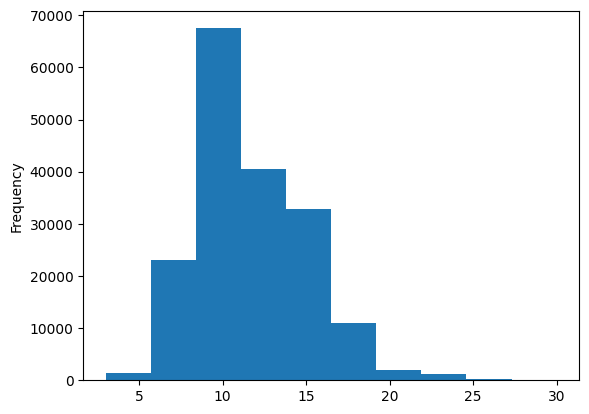

In [15]:
# Let's check the length of different lines
_ = train_df.total_lines.plot.hist()

## Get lists of sentences

In [16]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

## make numeric labels (ML models require numeric labels)

In [17]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder

In [18]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

In [19]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label encode labels

In [20]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_label_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_label_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_label_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [21]:
# Get class anmes and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Getting a baseline (TF-IDF Multinomial Naive Bayes Classifier)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])
model_0.fit(
    X=train_sentences,
    y=train_label_encoded
)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
# Evaluate baseline model on validation dataset
model_0_score = model_0.score(val_sentences, val_label_encoded) 
model_0_score

0.7218323844829869

In [24]:
model_0_preds = model_0.predict(val_sentences)

In [25]:
model_0_results = calculate_results(
    val_label_encoded,
    model_0_preds
)
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 1: CNN

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [27]:
# How long is each sentence on average?
sentence_lengths = [len(s.split()) for s in train_sentences]
avg_sentence_length = sum(sentence_lengths) / len(train_sentences)
avg_sentence_length

26.338269273494777

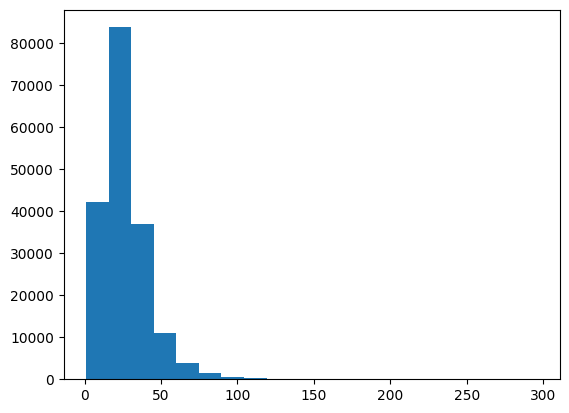

In [28]:
import matplotlib.pyplot as plt
_ = plt.hist(sentence_lengths, bins=20)

In [29]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sentence_lengths, 95))
output_seq_len

55

In [30]:
# Maximum sequence length in the training set
max(sentence_lengths)

296

In [31]:
max_tokens = 68000
# Create text vectorizer
vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=output_seq_len
)
vectorizer.adapt(train_sentences)

In [32]:
# Create embeddings
embeddings = layers.Embedding(
    input_dim=max_tokens,
    output_dim=128,
    input_length=output_seq_len
)

In [33]:
# turn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [34]:
# Create model
inputs = layers.Input(shape=(1,), dtype="string")
x = vectorizer(inputs)
x = embeddings(x)
x = layers.Conv1D(64, 5, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)
model_1.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)
model_1_history = model_1.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset
)
model_1_score = model_1.evaluate(val_dataset)
model_1_results = calculate_results(val_labels_one_hot, tf.squeeze(tf.round(model_1.predict(val_sentences))))

Epoch 1/5
5627/5627 [==============================] - 39s 6ms/step - loss: 0.5565 - accuracy: 0.7941 - val_loss: 0.4836 - val_accuracy: 0.8232
Epoch 2/5
5627/5627 [==============================] - 19s 3ms/step - loss: 0.3644 - accuracy: 0.8720 - val_loss: 0.5143 - val_accuracy: 0.8186
Epoch 3/5
5627/5627 [==============================] - 19s 3ms/step - loss: 0.2174 - accuracy: 0.9295 - val_loss: 0.6102 - val_accuracy: 0.8070
Epoch 4/5
5627/5627 [==============================] - 19s 3ms/step - loss: 0.1119 - accuracy: 0.9677 - val_loss: 0.7438 - val_accuracy: 0.7958
Epoch 5/5
945/945 [==============================] - 1s 849us/step


In [35]:
models_results = {
    "model_0": model_0_results, 
    "model_1": model_1_results
}
pd.DataFrame(models_results).transpose()

,accuracy,precision,recall,f1
model_0,72.183238,0.718647,0.721832,0.698925
model_1,78.587978,0.794785,0.785880,0.789690


## Model 2: Feature extraction token enoder

In [36]:
import tensorflow_hub as hub
# Create a Keras Layer using the pretrained USE (universal sentence encoder) layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[],
    dtype=tf.string,
    trainable=False,
    name="universal_sentence_encoder"
)

In [37]:
model_2 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(128, activation="relu"),
    layers.Dense(5, activation="softmax")
], name="model_2")

model_2.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)
model_2_history = model_2.fit(
    train_dataset,
    epochs=5,
    steps_per_epoch=int(0.2 * len(train_dataset)),
    validation_data=val_dataset
)
model_2_score = model_2.evaluate(val_dataset)
model_2_results = calculate_results(
    val_label_encoded, 
    tf.argmax(model_2.predict(val_sentences), axis=1)
)
models_results["model_2"] = model_2_results
pd.DataFrame(models_results).transpose()

Epoch 1/5
1125/1125 [==============================] - 13s 8ms/step - loss: 0.3075 - accuracy: 0.6600 - val_loss: 0.2649 - val_accuracy: 0.7108
Epoch 2/5
1125/1125 [==============================] - 9s 8ms/step - loss: 0.2570 - accuracy: 0.7176 - val_loss: 0.2502 - val_accuracy: 0.7294
Epoch 3/5
1125/1125 [==============================] - 9s 8ms/step - loss: 0.2522 - accuracy: 0.7241 - val_loss: 0.2419 - val_accuracy: 0.7371
Epoch 4/5
1125/1125 [==============================] - 9s 8ms/step - loss: 0.2399 - accuracy: 0.7402 - val_loss: 0.2354 - val_accuracy: 0.7464
Epoch 5/5
945/945 [==============================] - 4s 4ms/step


,accuracy,precision,recall,f1
model_0,72.183238,0.718647,0.721832,0.698925
model_1,78.587978,0.794785,0.785880,0.789690
model_2,74.728585,0.741444,0.747286,0.742109


## Char level vectorizer and embeddings

In [38]:

# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


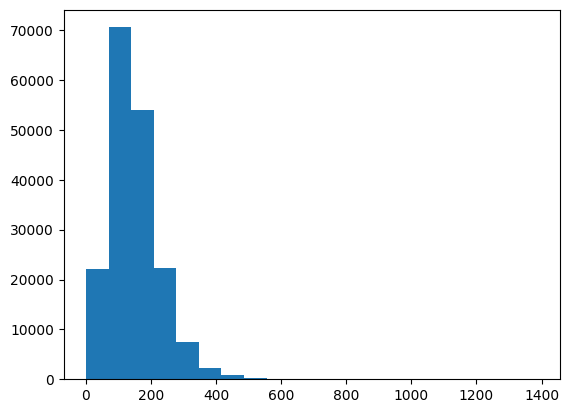

In [39]:
import matplotlib.pyplot as plt
_ = plt.hist([len(s) for s in train_sentences], bins=20)

In [40]:
# How long of a sentence length covers 95% of examples?
output_seq_len_c = int(np.percentile([len(s) for s in train_sentences], 95))
output_seq_len_c

290

In [41]:
# Get chars
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

In [78]:
NUM_CHAR_TOKEN = len(alphabet) + 2
char_vectorizer = layers.TextVectorization(
    max_tokens=NUM_CHAR_TOKEN,
    output_sequence_length=output_seq_len_c,
    name="char_vectorizer"
)

In [79]:
char_vectorizer.adapt([" ".join(list(s)) for s in train_sentences])

In [44]:
len(char_vectorizer.get_vocabulary())

28

In [45]:
char_embeddings_layer = layers.Embedding(
    input_dim=NUM_CHAR_TOKEN,
    output_dim=25,
    input_length=output_seq_len_c
)

In [46]:
# Create model
inputs = layers.Input(shape=(1,), dtype="string")
x = char_vectorizer(inputs)
x = char_embeddings_layer(x)
x = layers.Conv1D(64, 5, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs)
model_3.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)
model_3_history = model_3.fit(
    train_char_dataset,
    epochs=5,
    validation_data=val_char_dataset
)
model_3_score = model_3.evaluate(val_char_dataset)
model_3_results = calculate_results(
    val_label_encoded, 
    tf.argmax(model_3.predict(val_chars), axis=1)
)
models_results["model_3"] = model_3_results
pd.DataFrame(models_results).transpose()

Epoch 1/5
5627/5627 [==============================] - 13s 2ms/step - loss: 0.9003 - accuracy: 0.6499 - val_loss: 0.7906 - val_accuracy: 0.6955
Epoch 2/5
5627/5627 [==============================] - 12s 2ms/step - loss: 0.7611 - accuracy: 0.7092 - val_loss: 0.7463 - val_accuracy: 0.7138
Epoch 3/5
5627/5627 [==============================] - 12s 2ms/step - loss: 0.7285 - accuracy: 0.7222 - val_loss: 0.7248 - val_accuracy: 0.7231
Epoch 4/5
5627/5627 [==============================] - 12s 2ms/step - loss: 0.7099 - accuracy: 0.7302 - val_loss: 0.7147 - val_accuracy: 0.7271
Epoch 5/5
945/945 [==============================] - 1s 1ms/step


,accuracy,precision,recall,f1
model_0,72.183238,0.718647,0.721832,0.698925
model_1,78.587978,0.794785,0.785880,0.789690
model_2,74.728585,0.741444,0.747286,0.742109
model_3,72.841917,0.723347,0.728419,0.720404


## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

1. Create a token-level embedding model
2. Create a character level embedding model
3. Combine 1 & 2 with a concatenate (layers.Concanate)
4. Build series of output layers on top of 3.
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [47]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = sentence_encoder_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(
    token_inputs,
    token_outputs
)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embeddings_layer(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(
    char_inputs,
    char_bi_lstm
)

# 3. Concanate token and char inputs
token_char_concat = layers.Concatenate(name="token_char_hybrid")([
    token_model.output,
    char_model.output
])

# 4. Build series of layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(
    inputs=[token_inputs, char_inputs],
    outputs=output_layer,
    name="model_5"
)
model_4.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

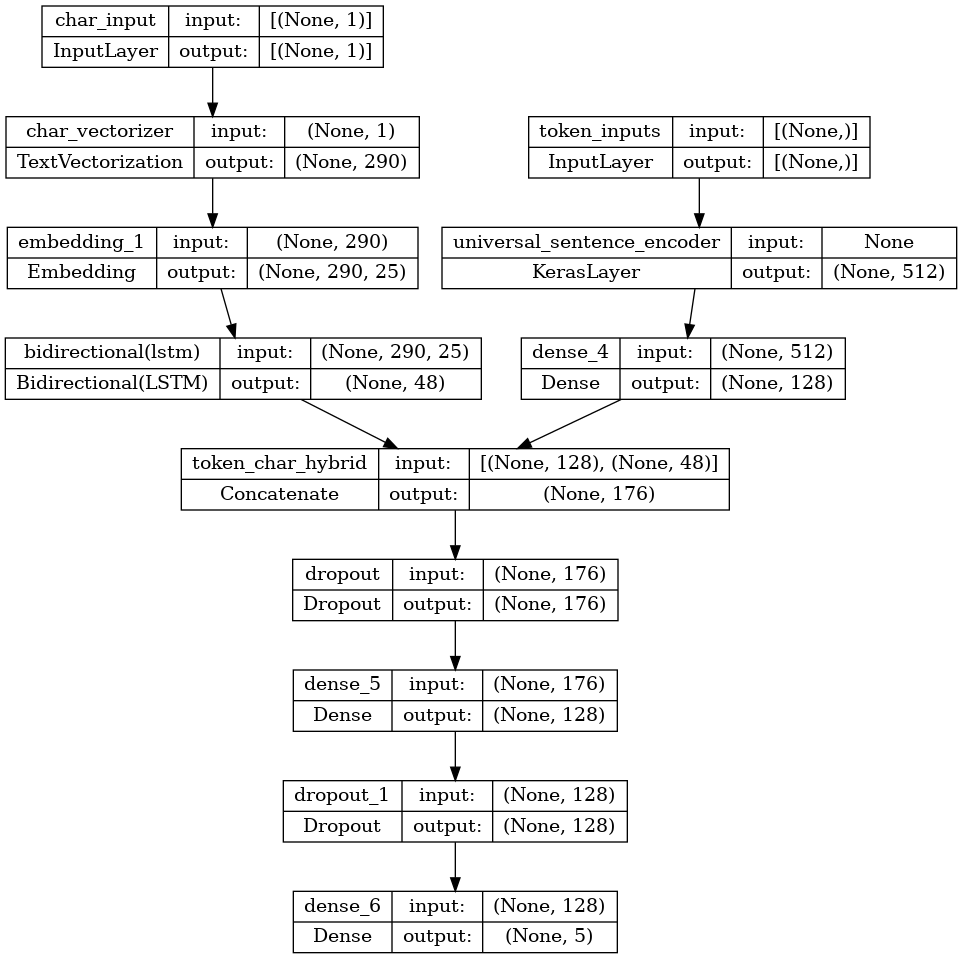

In [48]:
# Plot hybrid token and char model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [49]:
# Compile model 4
model_4.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

## Combining token and char training data

In [50]:
# Combine chars and tokens into a dataset
train_token_char_data = tf.data.Dataset.from_tensor_slices((
    train_sentences, 
    train_chars
))
train_token_char_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_dataset = tf.data.Dataset.zip((
    train_token_char_data, 
    train_token_char_labels
)).batch(32).prefetch(tf.data.AUTOTUNE)

In [51]:
# Same for validation data
val_token_char_data = tf.data.Dataset.from_tensor_slices((
    val_sentences, 
    val_chars
))
val_token_char_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_dataset = tf.data.Dataset.zip((
    val_token_char_data, 
    val_token_char_labels
)).batch(32).prefetch(tf.data.AUTOTUNE)

In [52]:
# And test dataset
test_token_char_data = tf.data.Dataset.from_tensor_slices((
    test_sentences, 
    test_chars
))
test_token_char_labels = tf.data.Dataset.from_tensor_slices((test_labels_one_hot))
test_char_token_dataset = tf.data.Dataset.zip((
    test_token_char_data, 
    test_token_char_labels
)).batch(32).prefetch(tf.data.AUTOTUNE)

In [53]:
model_4_history = model_4.fit(
    train_char_token_dataset,
    epochs=5,
    validation_data=val_char_token_dataset
)

Epoch 1/5
5627/5627 [==============================] - 73s 12ms/step - loss: 0.7643 - accuracy: 0.7081 - val_loss: 0.6316 - val_accuracy: 0.7599
Epoch 2/5
5627/5627 [==============================] - 65s 12ms/step - loss: 0.6802 - accuracy: 0.7439 - val_loss: 0.5980 - val_accuracy: 0.7746
Epoch 3/5
5627/5627 [==============================] - 65s 12ms/step - loss: 0.6532 - accuracy: 0.7545 - val_loss: 0.5791 - val_accuracy: 0.7819
Epoch 4/5
5627/5627 [==============================] - 65s 12ms/step - loss: 0.6383 - accuracy: 0.7605 - val_loss: 0.5732 - val_accuracy: 0.7814
Epoch 5/5
5627/5627 [==============================] - 65s 12ms/step - loss: 0.6245 - accuracy: 0.7660 - val_loss: 0.5654 - val_accuracy: 0.7862


In [54]:
model_4_score = model_4.evaluate(val_char_token_dataset)
model_4_results = calculate_results(
    val_label_encoded, 
    tf.argmax(model_4.predict(val_char_token_dataset), axis=1)
)
models_results["model_4"] = model_4_results
pd.DataFrame(models_results).transpose()

945/945 [==============================] - 6s 5ms/step


,accuracy,precision,recall,f1
model_0,72.183238,0.718647,0.721832,0.698925
model_1,78.587978,0.794785,0.785880,0.789690
model_2,74.728585,0.741444,0.747286,0.742109
model_3,72.841917,0.723347,0.728419,0.720404
model_4,78.621078,0.785761,0.786211,0.782266


## Model 5: Pretrained token embeddings + pretrained char embeddings + positional embeddings

In [77]:
char_vectorizer_2 = layers.TextVectorization(
    max_tokens=NUM_CHAR_TOKEN,
    output_sequence_length=output_seq_len_c,
    name="char_vectorizer",
    split="character"
)
char_vectorizer_2.adapt(train_sentences)

### Create positional embeddings

In [58]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11


In [59]:
# How many different lin_numbers are there
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

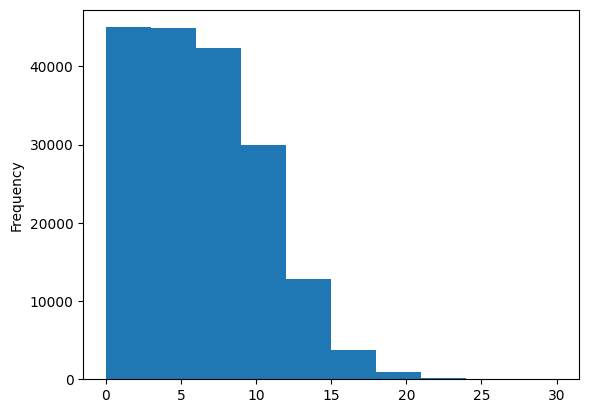

In [61]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [64]:
# Use tensorflow to create ont-hit-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:5], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [65]:
# How many different numbers of "total_lines" are there
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

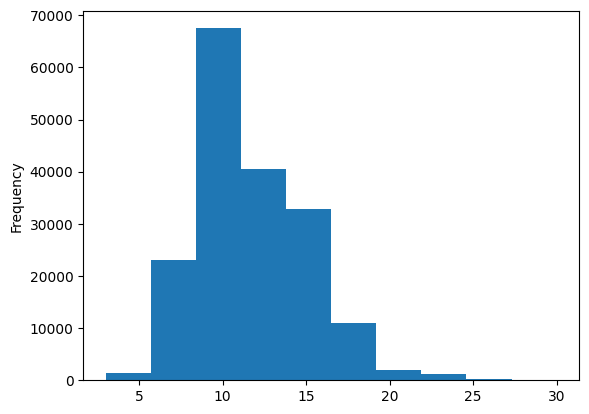

In [66]:
# Check the distribution of "total_lines" column
train_df.total_lines.plot.hist()

In [67]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [68]:
# Use TensorFLow to create one hot encoded tensors for total lines columns
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.Concatenate
7. Create the output layer to accept the tribried embedding and outptu label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model

In [80]:
# 1. Token model
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = sentence_encoder_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Char model
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embeddings_layer(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Line number model
line_num_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_num_inputs)
line_number_model = tf.keras.Model(line_num_inputs, x)

# 4. Total line model
total_line_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
x = layers.Dense(32, activation="relu")(total_line_inputs)
total_lines_models = tf.keras.Model(total_line_inputs, x)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embedding = layers.Concatenate(name="char_token_hybrid_embedding")([
    token_model.output,
    char_model.output
])

z = layers.Dense(256, activation="relu")(combined_embedding)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embedding
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embeddings")([
    line_number_model.output,
    total_lines_models.output,
    z
])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layers")(tribrid_embeddings)

# 8.Put together model with all kinds of inputs
model_5 = tf.keras.Model(
    inputs=[
        line_number_model.input,
        total_lines_models.input,
        token_model.input,
        char_model.input
    ],
    outputs=output_layer
)
model_5.summary()

Model: "model_42"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]'] 

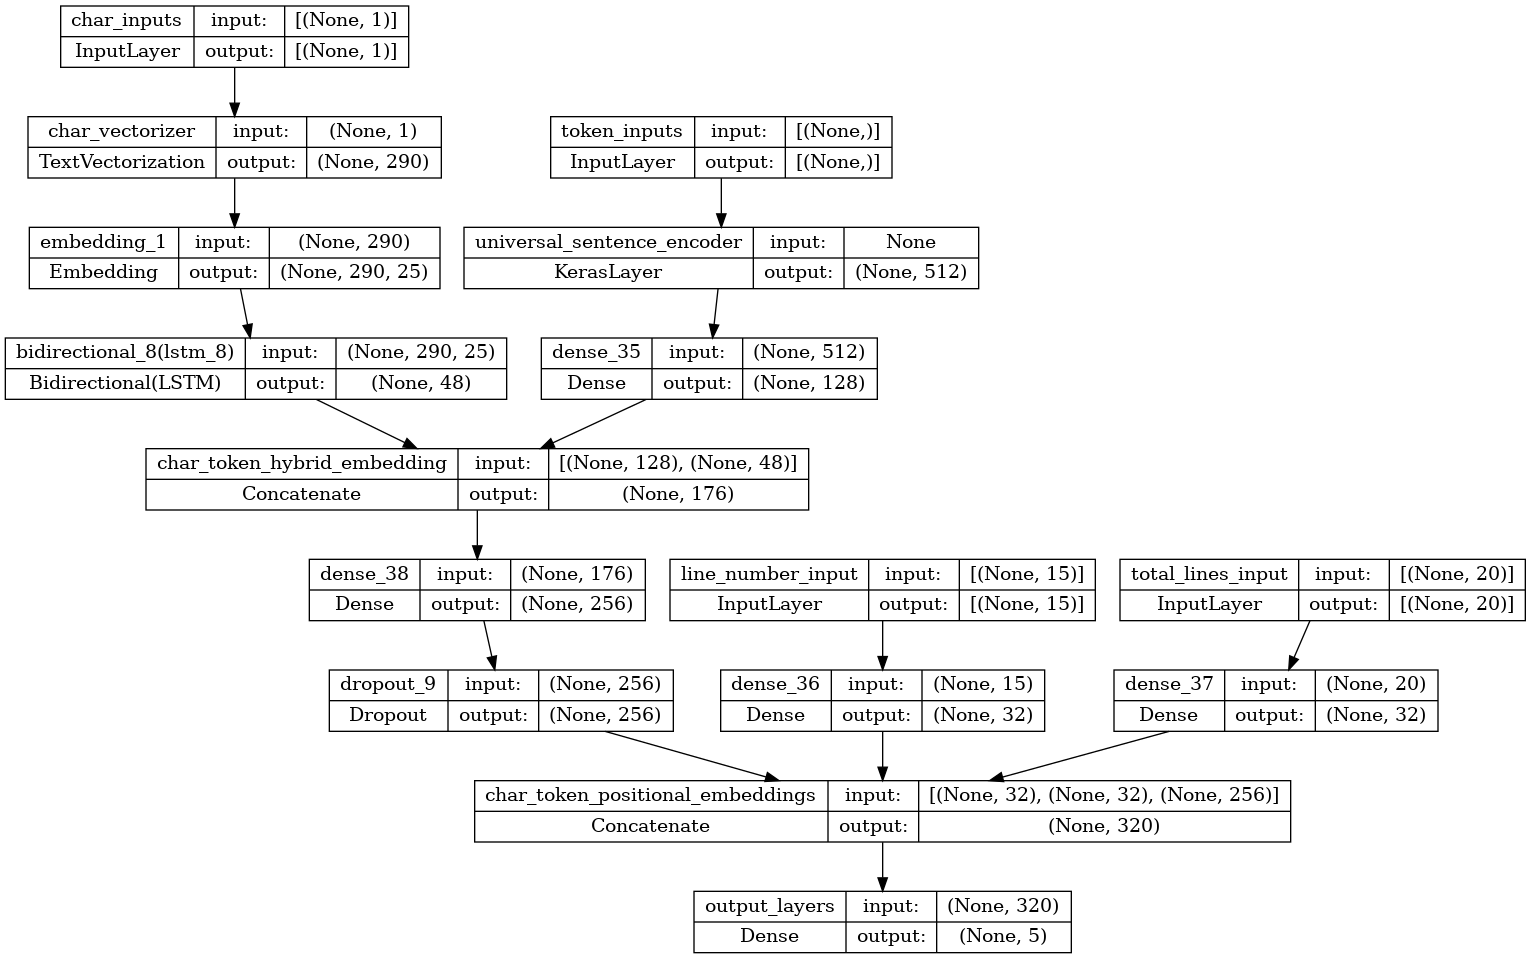

In [82]:
plot_model(model_5, show_shapes=True)

In [83]:
# Combine model 5
model_5.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # Helps to prevent overfitting
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

### Create tribrid embeddings dataset suing tf.data

In [85]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((
    train_line_numbers_one_hot,
    train_total_lines_one_hot,
    train_sentences,
    train_chars
))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((
    train_char_token_pos_data,
    train_char_token_pos_labels
)).batch(32).prefetch(tf.data.AUTOTUNE)


val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((
    val_line_numbers_one_hot,
    val_total_lines_one_hot,
    val_sentences,
    val_chars
))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((
    val_char_token_pos_data,
    val_char_token_pos_labels
)).batch(32).prefetch(tf.data.AUTOTUNE)


test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((
    test_line_numbers_one_hot,
    test_total_lines_one_hot,
    test_sentences,
    test_chars
))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((
    test_char_token_pos_data,
    test_char_token_pos_labels
)).batch(32).prefetch(tf.data.AUTOTUNE)

### Fit model 5

In [86]:
model_5_history = model_5.fit(
    train_char_token_pos_dataset,
    epochs=5,
    validation_data=val_char_token_pos_dataset
)
model_5_score = model_5.evaluate(val_char_token_pos_dataset)
model_5_results = calculate_results(
    val_label_encoded, 
    tf.argmax(model_5.predict(val_char_token_pos_dataset), axis=1)
)
models_results["model_5"] = model_5_results
pd.DataFrame(models_results).transpose()

Epoch 1/5
5627/5627 [==============================] - 75s 12ms/step - loss: 0.9529 - accuracy: 0.8236 - val_loss: 0.9081 - val_accuracy: 0.8483
Epoch 2/5
5627/5627 [==============================] - 68s 12ms/step - loss: 0.9079 - accuracy: 0.8551 - val_loss: 0.8985 - val_accuracy: 0.8553
Epoch 3/5
5627/5627 [==============================] - 67s 12ms/step - loss: 0.8952 - accuracy: 0.8641 - val_loss: 0.8967 - val_accuracy: 0.8558
Epoch 4/5
5627/5627 [==============================] - 67s 12ms/step - loss: 0.8867 - accuracy: 0.8700 - val_loss: 0.8983 - val_accuracy: 0.8530
Epoch 5/5
945/945 [==============================] - 6s 5ms/step


,accuracy,precision,recall,f1
model_0,72.183238,0.718647,0.721832,0.698925
model_1,78.587978,0.794785,0.785880,0.789690
model_2,74.728585,0.741444,0.747286,0.742109
model_3,72.841917,0.723347,0.728419,0.720404
model_4,78.621078,0.785761,0.786211,0.782266
model_5,85.499139,0.856615,0.854991,0.852505


<Axes: >

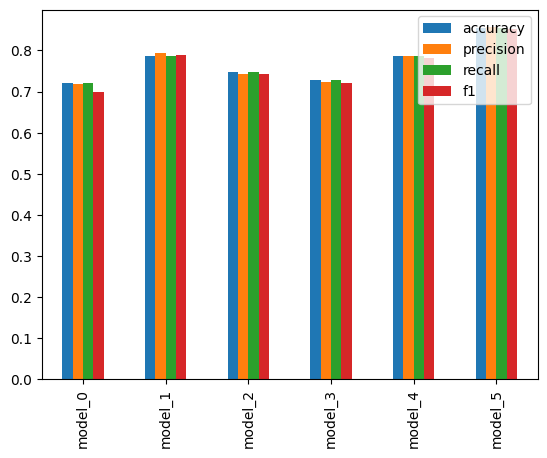

In [93]:
model_results_df = pd.DataFrame(models_results).transpose()
model_results_df["accuracy"] = model_results_df["accuracy"] / 100
model_results_df.plot.bar()

<Axes: >

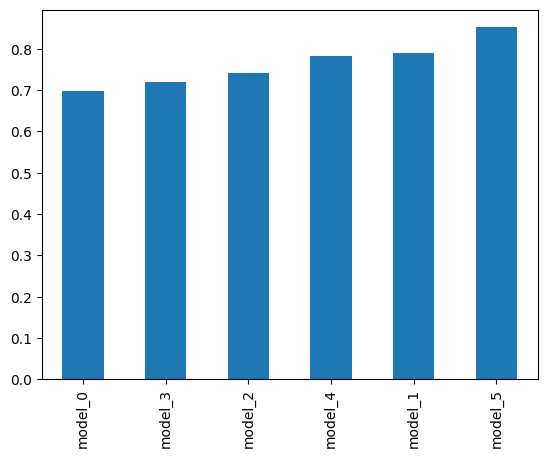

In [94]:
# Sort model_results by f1-score
model_results_df.sort_values("f1", ascending=True)["f1"].plot.bar( )

In [95]:
!rm helper_functions.py
!rm model.png
!rm -rf pubmed-rct/